In [1]:
import os
import numpy
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv("../data/metadata/reference.csv")

In [3]:
nd = np.random.rand(len(df))

In [4]:
df.head()

,PatientID,probCOVID,probSevere
0,8622,1,0
1,1072,1,0
2,10456,1,0
3,2063,1,0
4,9448,1,0


In [5]:
df_train = df[nd < 0.9].reset_index(drop=True)
df_val = df[0.9 <= nd].reset_index(drop=True)

# Visualization

In [6]:
"""
values = df_train.probCOVID.value_counts()
labels = ['Active', 'Inactive']
plt.figure(figsize=(16, 12))
plt.pie(values, labels = labels)
plt.legend()
plt.title("probCOVID")
plt.show() 
"""

'\nvalues = df_train.probCOVID.value_counts()\nlabels = [\'Active\', \'Inactive\']\nplt.figure(figsize=(16, 12))\nplt.pie(values, labels = labels)\nplt.legend()\nplt.title("probCOVID")\nplt.show() \n'

In [7]:
"""
values = df_train.probSevere.value_counts()
labels = ['Yes', 'No']
plt.figure(figsize=(16, 12))
plt.pie(values, labels = labels)
plt.legend()
plt.title("probSevere")
plt.show()
"""

'\nvalues = df_train.probSevere.value_counts()\nlabels = [\'Yes\', \'No\']\nplt.figure(figsize=(16, 12))\nplt.pie(values, labels = labels)\nplt.legend()\nplt.title("probSevere")\nplt.show()\n'

In [8]:
"""
import numpy as np
import SimpleITK as sitk
from typing import Iterable
def clip_and_normalize(np_image: np.ndarray,
                       clip_min: int = -1100,
                       clip_max: int = 300
                       ) -> np.ndarray:
    np_image = np.clip(np_image, clip_min, clip_max)
    np_image = (np_image - clip_min) / (clip_max - clip_min)
    return np_image


def resample(itk_image: sitk.Image,
             new_spacing: Iterable[float],
             outside_val: float = 0
             ) -> sitk.Image:

    shape = itk_image.GetSize()
    spacing = itk_image.GetSpacing()
    output_shape = tuple(int(round(s * os / ns)) for s, os, ns in zip(shape, spacing, new_spacing))
    return sitk.Resample(
        itk_image,
        output_shape,
        sitk.Transform(),
        sitk.sitkLinear,
        itk_image.GetOrigin(),
        new_spacing,
        itk_image.GetDirection(),
        outside_val,
        sitk.sitkFloat32,
    )

def center_crop(np_image: np.ndarray,
                new_shape: Iterable[int],
                outside_val: float = 0
                ) -> np.ndarray:
    output_image = np.full(new_shape, outside_val, np_image.dtype)

    slices = tuple()
    offsets = tuple()
    for it, sh in enumerate(new_shape):
        size = sh // 2
        if it == 0:
            center = np_image.shape[it] - size
        else:
            center = (np_image.shape[it] // 2)
        start = center - size
        stop = center + size + (sh % 2)

        # computing what area of the original image will be in the cropped output
        slce = slice(max(0, start), min(np_image.shape[it], stop))
        slices += (slce,)

        # computing offset to pad if the crop is partly outside of the scan
        offset = slice(-min(0, start), 2 * size - max(0, (start + 2 * size) - np_image.shape[it]))
        offsets += (offset,)

    output_image[offsets] = np_image[slices]

    return output_image


def preprocess(input_image: sitk.Image,
               new_spacing: Iterable[float] = (1.6, 1.6, 1.6),
               new_shape: Iterable[int] = (240, 240, 240),
               ) -> np.ndarray:

    input_image = resample(input_image, new_spacing=new_spacing)
    input_image = sitk.GetArrayFromImage(input_image)
    input_image = center_crop(input_image, new_shape=new_shape)
    input_image = clip_and_normalize(input_image)
    return input_image

def show(im, title):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(im[im.shape[0] // 2, :, :])
        ax2.imshow(im[:, im.shape[1] // 2, :])
        ax3.imshow(im[:, :, im.shape[2] // 2])
        plt.title(title)
        plt.show()
        
def visualization(image_path):    
    input_image = sitk.ReadImage(image_path)
    input_image = resample(input_image, new_spacing=(1.6, 1.6, 1.6))
    input_image = sitk.GetArrayFromImage(input_image)
    input_image = center_crop(input_image, new_shape=(240, 240, 240))
    input_image = clip_and_normalize(input_image)
    show(input_image, 'clipped')
"""

"\nimport numpy as np\nimport SimpleITK as sitk\nfrom typing import Iterable\ndef clip_and_normalize(np_image: np.ndarray,\n                       clip_min: int = -1100,\n                       clip_max: int = 300\n                       ) -> np.ndarray:\n    np_image = np.clip(np_image, clip_min, clip_max)\n    np_image = (np_image - clip_min) / (clip_max - clip_min)\n    return np_image\n\n\ndef resample(itk_image: sitk.Image,\n             new_spacing: Iterable[float],\n             outside_val: float = 0\n             ) -> sitk.Image:\n\n    shape = itk_image.GetSize()\n    spacing = itk_image.GetSpacing()\n    output_shape = tuple(int(round(s * os / ns)) for s, os, ns in zip(shape, spacing, new_spacing))\n    return sitk.Resample(\n        itk_image,\n        output_shape,\n        sitk.Transform(),\n        sitk.sitkLinear,\n        itk_image.GetOrigin(),\n        new_spacing,\n        itk_image.GetDirection(),\n        outside_val,\n        sitk.sitkFloat32,\n    )\n\ndef center

In [9]:
"""
for i in np.random.randint(len(df_train), size=25):
    image_name, probCOVID, probSevere = df_train.iloc[i]
    image_path = "../data/mha/" + str(image_name) + ".mha"
    visualization(image_path)
    print(f"probCOVID: {probCOVID}")
    print(f"probSevere: {probSevere}")
    print("*"*50)
"""

'\nfor i in np.random.randint(len(df_train), size=25):\n    image_name, probCOVID, probSevere = df_train.iloc[i]\n    image_path = "../data/mha/" + str(image_name) + ".mha"\n    visualization(image_path)\n    print(f"probCOVID: {probCOVID}")\n    print(f"probSevere: {probSevere}")\n    print("*"*50)\n'

# Data Processing

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from algorithm.preprocess import preprocess
from tensorflow.keras.utils import to_categorical

In [11]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dataset, batch_size, data_path):
        'Initialization'
        self.dataset = dataset
        self.batch_size = batch_size
        self.data_path  = data_path
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dataset) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_data = [self.dataset.iloc[k] for k in indexes]
        images, labels_1, labels_2 = self.__data_generation(batch_data)
        
        return (np.array(images), {"covid_output": np.array(labels_1), "severe_output":  np.array(labels_2)})

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dataset))

    def __data_generation(self, batch_data):
        images = []
        labels_1 = []
        labels_2 = []
        for name, label_1, label_2  in batch_data:
            image_path = self.data_path + str(name) + ".pkl"
            with open(image_path, 'rb') as f:
                input_image = pickle.load(f)
            images.append(input_image)
            labels_1.append(label_1)
            labels_2.append(label_2)
        return images, labels_1, labels_2         

In [12]:
train_generator = DataGenerator(df_train, 32, "../data/pkl/")
val_generator = DataGenerator(df_val, 32, "../data/pkl/")

In [13]:
image_size = (240, 240, 240)

# Model

In [14]:
import wandb
from wandb.keras import WandbCallback

In [15]:
wandb.init(project="stoic2021", entity="ngocdunghuynh")

wandb: Currently logged in as: ngocdunghuynh (use `wandb login --relogin` to force relogin)


In [16]:
##Parameter
config = {
    "lr": 1e-3,
    "epochs": 32,
    "model_name": "shallow",
    "covid_conv_hidden": 128,
    "covid_dense_hidden": 128,
    "covid_conv_number": 4,
    "severe_conv_hidden": 128,
    "severe_dense_hidden": 128,
    "severe_conv_number": 4,
    "drop_rate": 0.5
}

wandb.log(config)

model_name = config["model_name"]
lr = config["lr"]
epochs = config["epochs"]
covid_conv_hidden = config["covid_conv_hidden"]
covid_dense_hidden = config["covid_dense_hidden"]
covid_conv_number = config["covid_conv_number"]

severe_conv_hidden = config["severe_conv_hidden"]
severe_dense_hidden = config["severe_dense_hidden"]
severe_conv_number = config["severe_conv_number"]

drop_rate = config["drop_rate"]

In [17]:
from tensorflow.keras.layers import Input, BatchNormalization, Conv2D
from tensorflow.keras.layers import MaxPooling2D, Activation, Dropout, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import models

In [18]:
input_layer = Input(shape=(240, 240, 240), name = "input")
def covid_network(inputs, covid_conv_hidden, covid_dense_hidden, covid_conv_number, drop_rate):
    x = inputs
    for i in range(covid_conv_number):
        x = Conv2D(covid_conv_hidden, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(drop_rate)(x)

    x = Flatten()(x)
    x = Dense(covid_dense_hidden)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_rate)(x)
    x = Dense(1)(x)
    x = Activation("sigmoid", name = "covid_output")(x)
    # return the category prediction sub-network
    return x
def severe_network(inputs, severe_conv_hidden, severe_dense_hidden, severe_conv_number, drop_rate):
    x = inputs
    for i in range(severe_conv_number):
        x = Conv2D(severe_conv_hidden, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(drop_rate)(x)
    
    x = Flatten()(x)
    x = Dense(severe_dense_hidden)(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(drop_rate)(x)
    x = Dense(1)(x)
    x = Activation("sigmoid", name = "severe_output")(x)
    return x
covid_part = covid_network(input_layer, covid_conv_hidden, covid_dense_hidden, covid_conv_number, drop_rate)
severe_part = severe_network(input_layer, severe_conv_hidden, severe_dense_hidden, severe_conv_number, drop_rate)

2022-02-16 13:24:40.284152: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 13:24:40.301532: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 13:24:40.302033: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-16 13:24:40.302967: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [19]:
model = Model(inputs=input_layer,
              outputs=[covid_part, severe_part])

losses = {
    "covid_output": "binary_crossentropy",
    "severe_output": "binary_crossentropy",
}

lossWeights = {"covid_output": 0.3, "severe_output": 0.7}
opt = Adam(learning_rate = lr, decay=lr / epochs)
model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights,metrics=[tf.keras.metrics.AUC(), "accuracy"])

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 240, 240, 2  0           []                               
                                40)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, 240, 240, 12  276608      ['input[0][0]']                  
                                8)                                                                
                                                                                                  
 conv2d_4 (Conv2D)              (None, 240, 240, 12  276608      ['input[0][0]']                  
                                8)                                                            

                                                                                                  
 batch_normalization_3 (BatchNo  (None, 8, 8, 128)   512         ['activation_3[0][0]']           
 rmalization)                                                                                     
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 8, 8, 128)   512         ['activation_8[0][0]']           
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_3 (MaxPooling2D)  (None, 2, 2, 128)   0           ['batch_normalization_3[0][0]']  
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 2, 2, 128)   0           ['batch_normalization_8[0][0]']  
          

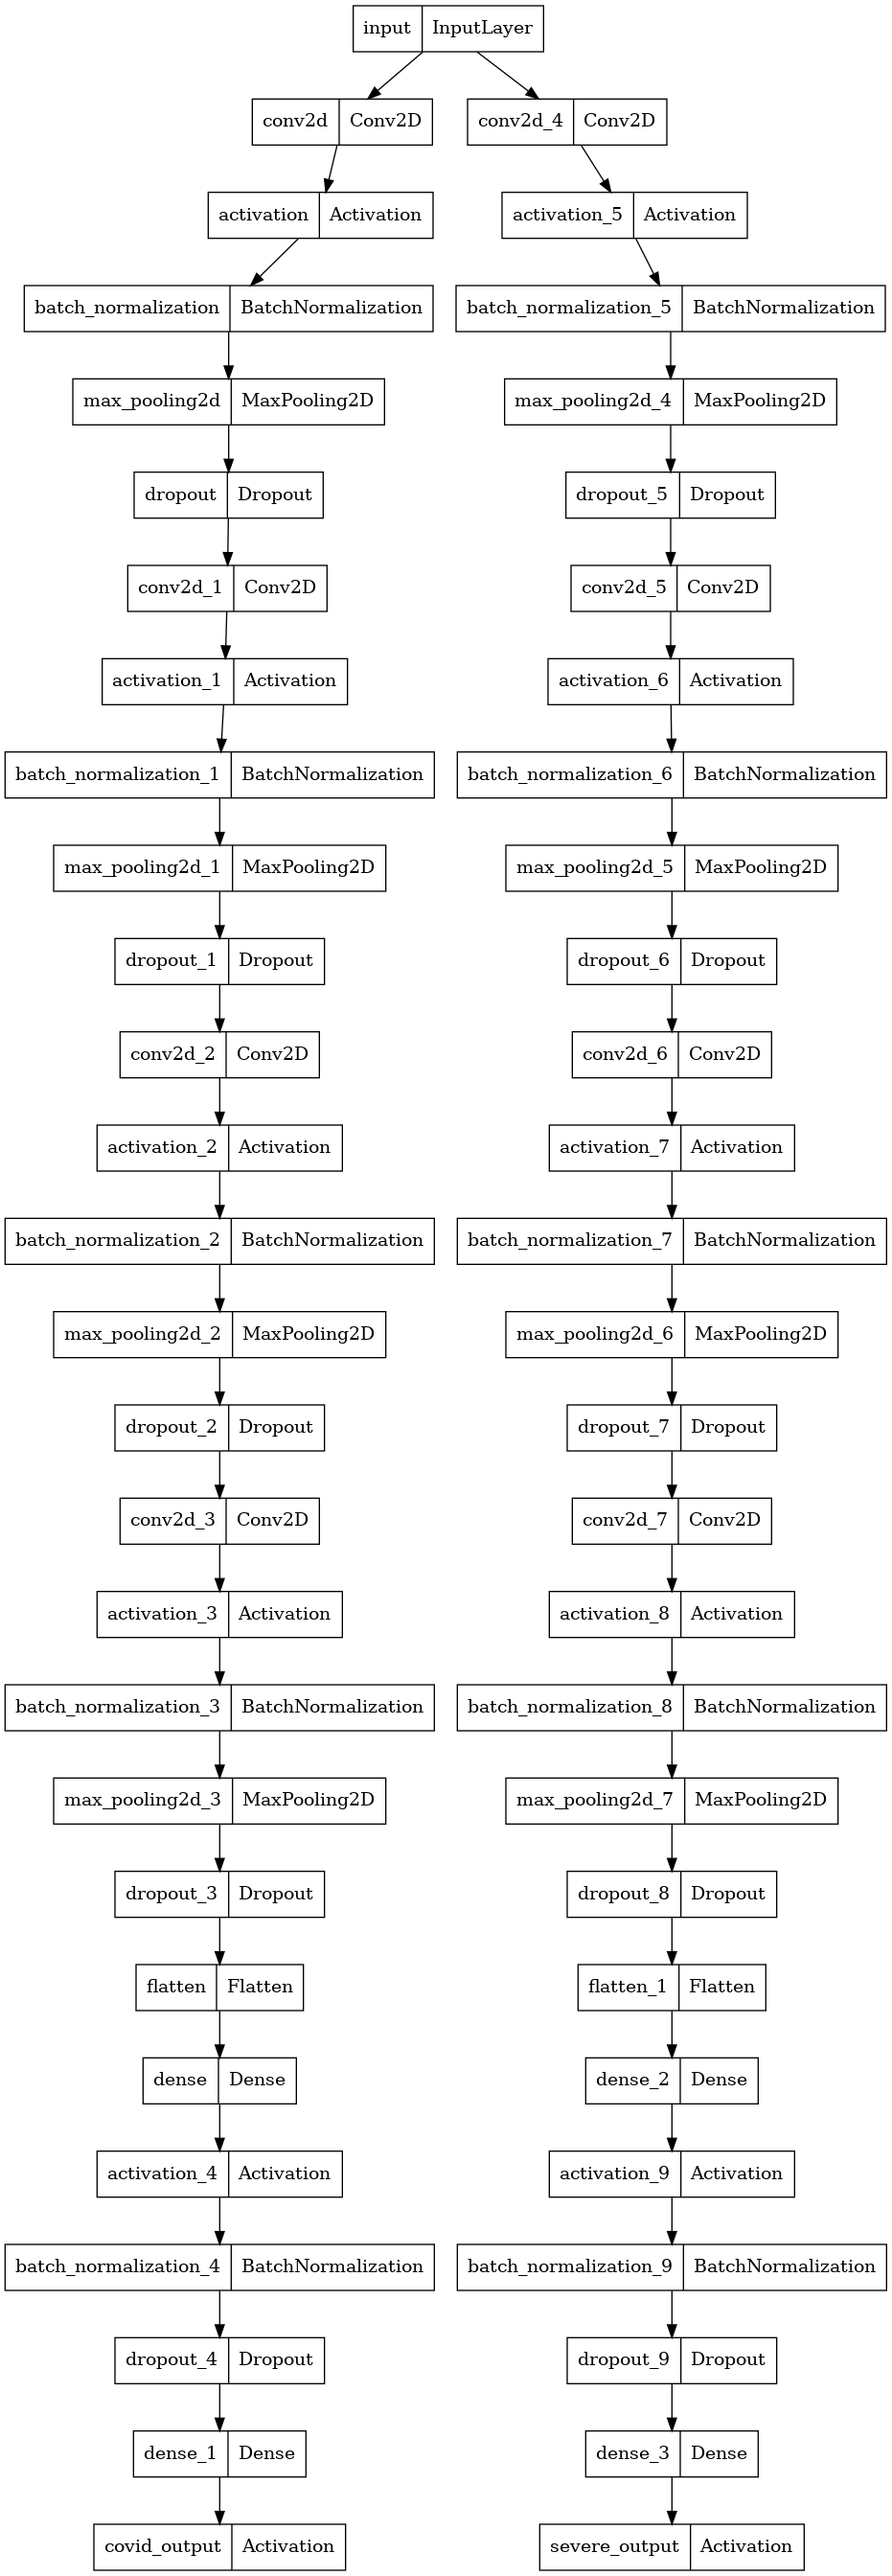

In [21]:
tf.keras.utils.plot_model(model)

# Trainning

In [22]:
save_model = ModelCheckpoint(f'./save_models/{model_name}/', monitor="val_severe_output_auc", save_best_only=True, mode='max')
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience= 10)

In [23]:
model = models.load_model('./save_models/shallow/')

In [24]:
history = model.fit(train_generator,
                    validation_data= val_generator,
                    epochs= epochs,
                    callbacks=[stop_early, save_model, WandbCallback()]
                   )

Epoch 1/32


2022-02-16 13:24:44.114431: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1769472000 exceeds 10% of free system memory.
2022-02-16 13:24:47.464878: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1769472000 exceeds 10% of free system memory.
2022-02-16 13:24:48.800719: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2022-02-16 13:24:49.609335: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.
2022-02-16 13:24:49.610663: W tensorflow/stream_executor/gpu/asm_compiler.cc:230] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.6
2022-02-16 13:24:49.610689: W tensorflow/stream_executor/gpu/asm_compiler.cc:233] Used ptx

 2/56 [>.............................] - ETA: 20s - loss: 0.4671 - covid_output_loss: 0.6376 - severe_output_loss: 0.3940 - covid_output_auc: 0.6406 - covid_output_accuracy: 0.6719 - severe_output_auc: 0.4586 - severe_output_accuracy: 0.8906 

2022-02-16 13:24:54.596082: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1769472000 exceeds 10% of free system memory.


 3/56 [>.............................] - ETA: 1:23 - loss: 0.4290 - covid_output_loss: 0.6213 - severe_output_loss: 0.3467 - covid_output_auc: 0.6660 - covid_output_accuracy: 0.6875 - severe_output_auc: 0.6047 - severe_output_accuracy: 0.8958

2022-02-16 13:24:57.430455: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1769472000 exceeds 10% of free system memory.


56/56 [==============================] - ETA: 0s - loss: 0.4671 - covid_output_loss: 0.6462 - severe_output_loss: 0.3903 - covid_output_auc: 0.6411 - covid_output_accuracy: 0.6345 - severe_output_auc: 0.6875 - severe_output_accuracy: 0.8532

2022-02-16 13:27:39.336804: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./save_models/shallow/assets
56/56 [==============================] - 176s 3s/step - loss: 0.4671 - covid_output_loss: 0.6462 - severe_output_loss: 0.3903 - covid_output_auc: 0.6411 - covid_output_accuracy: 0.6345 - severe_output_auc: 0.6875 - severe_output_accuracy: 0.8532 - val_loss: 0.5090 - val_covid_output_loss: 0.6440 - val_severe_output_loss: 0.4511 - val_covid_output_auc: 0.5837 - val_covid_output_accuracy: 0.6354 - val_severe_output_auc: 0.6866 - val_severe_output_accuracy: 0.8177
Epoch 2/32
56/56 [==============================] - 163s 3s/step - loss: 0.4626 - covid_output_loss: 0.6350 - severe_output_loss: 0.3888 - covid_output_auc: 0.6571 - covid_output_accuracy: 0.6456 - severe_output_auc: 0.7083 - severe_output_accuracy: 0.8454 - val_loss: 0.5956 - val_covid_output_loss: 0.7149 - val_severe_output_loss: 0.5445 - val_covid_output_auc: 0.6200 - val_covid_output_accuracy: 0.6667 - val_severe_output_auc: 0.6524 - val_severe_output_accuracy: 

56/56 [==============================] - 172s 3s/step - loss: 0.4302 - covid_output_loss: 0.5713 - severe_output_loss: 0.3698 - covid_output_auc: 0.7566 - covid_output_accuracy: 0.6981 - severe_output_auc: 0.7449 - severe_output_accuracy: 0.8521 - val_loss: 0.5049 - val_covid_output_loss: 0.6296 - val_severe_output_loss: 0.4514 - val_covid_output_auc: 0.6403 - val_covid_output_accuracy: 0.6302 - val_severe_output_auc: 0.6797 - val_severe_output_accuracy: 0.8229
Epoch 18/32
56/56 [==============================] - 168s 3s/step - loss: 0.4204 - covid_output_loss: 0.5713 - severe_output_loss: 0.3558 - covid_output_auc: 0.7512 - covid_output_accuracy: 0.6931 - severe_output_auc: 0.7762 - severe_output_accuracy: 0.8488 - val_loss: 0.5217 - val_covid_output_loss: 0.6911 - val_severe_output_loss: 0.4492 - val_covid_output_auc: 0.6191 - val_covid_output_accuracy: 0.6510 - val_severe_output_auc: 0.6646 - val_severe_output_accuracy: 0.8229
Epoch 19/32
56/56 [==============================] - 170

In [25]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

In [26]:
history.history["accuracy"] = (np.array(history.history['covid_output_accuracy']) + np.array(history.history['severe_output_accuracy']))/2
history.history["val_accuracy"] = (np.array(history.history['val_covid_output_accuracy']) + np.array(history.history['val_severe_output_accuracy']))/2

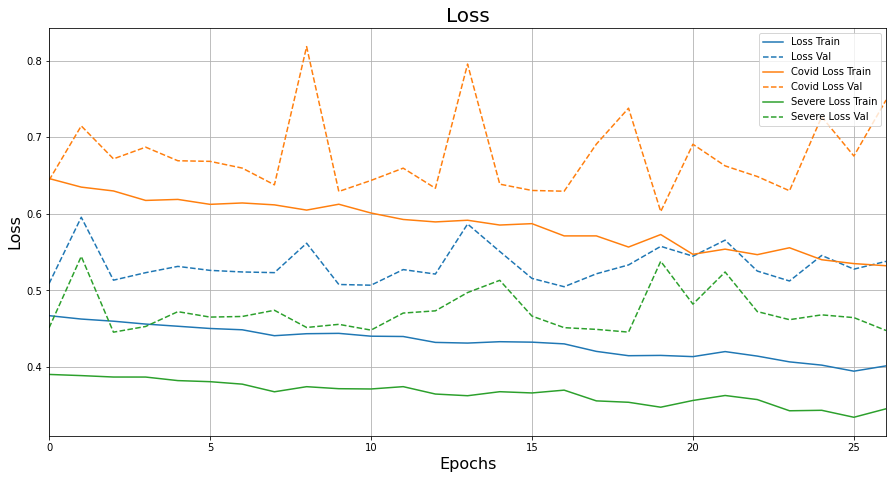

In [27]:
plt.figure(figsize=(15,7.5))
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Loss": history}, metric = "loss")
plotter.plot({"Covid Loss": history}, metric = "covid_output_loss")
plotter.plot({"Severe Loss": history}, metric = "severe_output_loss")
plt.title("Loss", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Loss", fontsize=16)
plt.show
plt.savefig(f'./save_models/{model_name}/Loss.png')

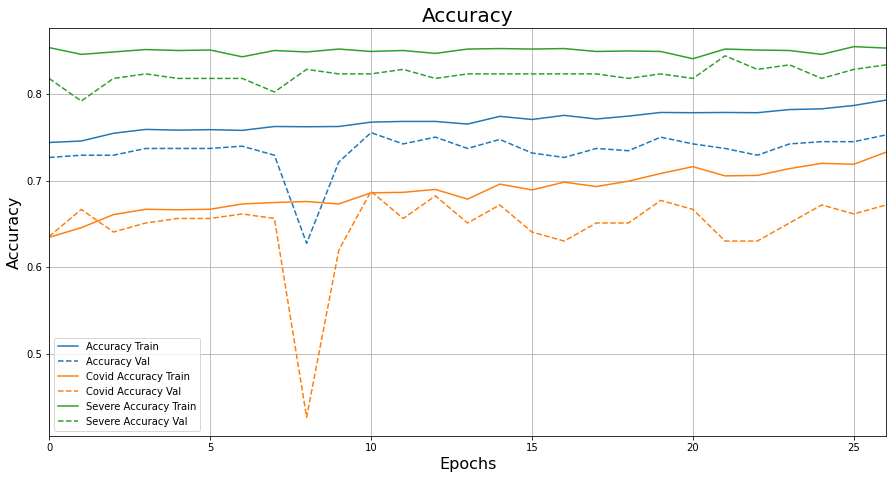

In [28]:
plt.figure(figsize=(15,7.5))
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Accuracy": history}, metric = "accuracy")
plotter.plot({"Covid Accuracy": history}, metric = "covid_output_accuracy")
plotter.plot({"Severe Accuracy": history}, metric = "severe_output_accuracy")
plt.title("Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.show
plt.savefig(f'./save_models/{model_name}/Accuracy.png')

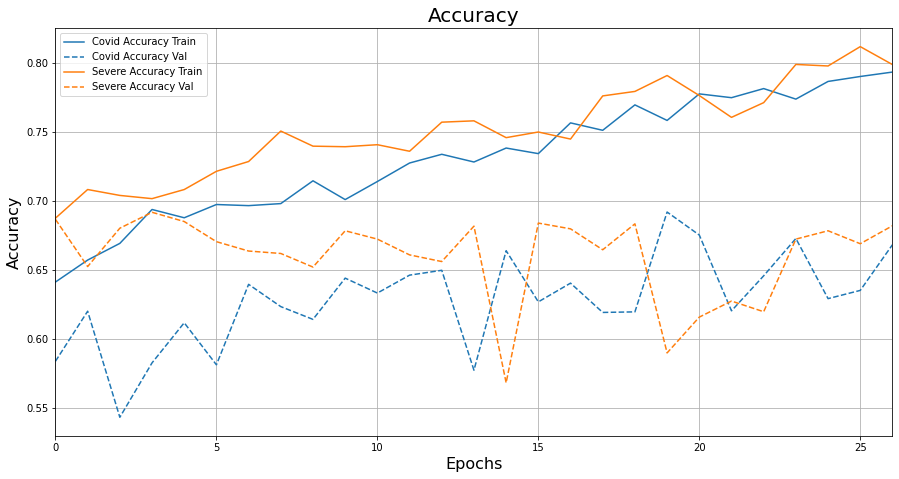

In [29]:
plt.figure(figsize=(15,7.5))
plotter = tfdocs.plots.HistoryPlotter()
plotter.plot({"Covid Accuracy": history}, metric = "covid_output_auc")
plotter.plot({"Severe Accuracy": history}, metric = "severe_output_auc")
plt.title("Accuracy", fontsize=20)
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.show
plt.savefig(f'./save_models/{model_name}/Accuracy.png')

In [30]:
os.environ["WANDB_SILENT"] = "true"